<h1> <u><center>Imports</center></u> </h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import operator as op
%matplotlib inline

/home/monish/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h1> <u><center>Constants</center></u> </h1>

In [2]:
FILE_PATH = 'DATA/loan.csv'
META_DAT_PATH = 'DATA/loan_metadata.txt'
DAT_DICT = 'DATA/Data_Dictionary.xlsx'
META_DAT_CLEAN = 'DATA/loan_metadat.csv'
ASP_RATIO = (12,6)

<h1> <u><center>Functions</center></u> </h1>

In [15]:
def read_data(filename):
    df = pd.read_csv(filename, low_memory=False)
    df_copy = df.copy()
    return df, df_copy

In [4]:
def save_df_info(df):
    with open(META_DAT_PATH, 'w') as f:
        df.info(max_cols=120);
        f.write(cap.stdout)

In [34]:
## to do analysis of the info output of the loan_dataset, this function will create a file with all 
## the required metadata about the loan dataset. This file will consist of missing percent of every
## single column, datatype and null or non-null object of the loan dataset
def create_meta_data_file(dataframe,filename):
    
    META_FILE_NAME = 'DATA/meta_data'+'.csv'
    meta_data = pd.read_csv(filename, sep='\t', skiprows=5, skipfooter=2, names=['columns_info'],
                           engine='python')
    meta_data['variable_name'] = meta_data.apply(lambda var:var[0].split(' ',1)[0], axis=1)
    meta_data['data_type'] =   meta_data.apply(lambda dat_type:dat_type[0].split(' ',1)[1], axis=1)

    meta_data['data_format'] = meta_data['data_type'].apply(lambda data_frmt: data_frmt.lstrip().split(' ')[2])
    meta_data['null_object_type'] = meta_data['data_type'].\
    apply(lambda null_obj: null_obj.lstrip()\
          .split(' ')[1])
    meta_data['no_of_rows'] = meta_data['data_type'].apply(lambda row: row.lstrip().split(' ')[0])
#     return meta_data
    
    del meta_data['data_type']
    
    meta_data['missing_percent'] = meta_data['no_of_rows'].astype('float')/dataframe.shape[0]
    meta_data['missing_percent'] = (1-(round(meta_data['no_of_rows'].astype('float')\
                                                   /dataframe.shape[0],2)))*100
    
    meta_data.to_csv(META_FILE_NAME, index=False)
    return META_FILE_NAME

In [6]:
## this function will return the p value after performing the chi square test

def perfrom_chi_2_test(df,col1,col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    _, p_val, _, *_ = stats.chi2_contingency(crosstab)
    print(f" P_value for chi_2 test between {col1} and {col2} {round(p_val,2)}")

In [7]:
def create_bins(df, col_name, new_col, *bin_intervals):

    column_ser = df[col_name]
    size_lis = len(bin_intervals)
    lb = df[col_name] <= bin_intervals[0]
    ub = df[col_name] > bin_intervals[-1]
    bin_intvls = []
    
    bin_intvls.append(lb)    
    for index, bin_interval in enumerate(bin_intervals):
        if index <= len(bin_intervals)-2:
            bin_intvls.append(op.gt(column_ser, bin_interval) & op.le(column_ser,bin_intervals[index+1]))
    bin_intvls.append(ub)
    
    for intvl_, bins in enumerate(bin_intvls):
        df.loc[bins, new_col] = 'interval'+'_'+str(intvl_)
    
    return bin_intvls


In [8]:
def plot_crosstab(df=None, col_names=None, x_label=None, y_label=None, labelsize=None, \
                  labelpad=None, pad=None, t_fontsize=None, ax_fontsize=None, plot_title=None, \
                  x_ticklabels=None, rotation=None, estimator=None, color=None, ls=None, \
                  hline=False, vline=False, aspect_ratio=None, sub_plots=False):
    if  ~sub_plots:
        fig_obj, ax_obj = plt.subplots(figsize=aspect_ratio)

    
    pd.crosstab(df[col_names[0]], df[col_names[1]])\
    .plot(kind='bar', ax=ax_obj);
    
    ax_obj.set_title(plot_title, pad=pad, fontsize=t_fontsize);
    ax_obj.set_xlabel(x_label, fontsize=ax_fontsize, labelpad=labelpad);
    ax_obj.set_ylabel(y_label, fontsize=ax_fontsize, labelpad=labelpad);
    ax_obj.tick_params(axis='both', which='major', labelsize=labelsize);
    ax_obj.set_xticklabels(x_ticklabels, rotation=rotation);
    
    if hline:
        ax_obj.axhline(estimator, ls=ls, color=color)
    if vline:
        ax_obj.axvline(estimator, ls=ls, color=color)
    

In [9]:
def generate_crosstab_summary(df,col1, col2):

    df_pivot = pd.crosstab(df[col1],df[col2])
    df_pivot['total'] = df_pivot[0]+df_pivot[1]
    df_pivot['avg_defaulter_row%'] = round((df_pivot[0]/(df_pivot['total']))*100,2)
    df_pivot['avg_non_defaulter_row%'] = round((df_pivot[1]/(df_pivot['total']))*100,2)
    df_pivot['avg_defaulter_diff_row%']= (df_pivot['avg_defaulter_row%']-df_pivot['avg_defaulter_row%'].min())
    
    df_pivot['avg_defaulter_col%'] = round((df_pivot[0]/(df_pivot[0].sum()))*100,2)
    df_pivot['avg_non_defaulter_col%'] = round((df_pivot[1]/(df_pivot[1].sum()))*100,2)
    df_pivot['avg_defaulter_diff_col%']= (df_pivot['avg_defaulter_col%']-df_pivot['avg_defaulter_col%'].min())
    
#     df_pivot.loc[1:,'avg_defaulter_diff_%'] = list(map(op.sub,df_pivot['avg_defaulter_%'].values[1:],\
#                                                 df_pivot['avg_defaulter_%'].values[:-1]))
#     list(map(op.sub,df_pivot['avg_defaulter_%'][1:],\
#                                                 df_pivot['avg_defaulter_%'][:-1]))
    del df_pivot[0]
    del df_pivot[1]
    col_ret = ['avg_defaulter_row%', 'avg_non_defaulter_row%','avg_defaulter_diff_row%',\
     'avg_defaulter_col%', 'avg_non_defaulter_col%','avg_defaulter_diff_col%']
    return df_pivot[col_ret].sort_index()


In [10]:
def configure_plot(plot_title=None, pad=None, t_fontsize=None, ax_fontsize=None, labelpad=None, labelsize=None,\
               x_label=None, y_label=None, ax_obj=None):
    ax_obj.set_title(plot_title, pad=pad, fontsize=t_fontsize);
    ax_obj.set_xlabel(x_label, fontsize=ax_fontsize, labelpad=labelpad);
    ax_obj.set_ylabel(y_label, fontsize=ax_fontsize, labelpad=labelpad);
    ax_obj.tick_params(axis='both', which='major', labelsize=labelsize);
#     ax_obj.xscale(x_scale)
#     ax_obj.yscale(y_scale)


In [11]:
def calculate_woe(df, col_names, bin_tar_col,*intvls):

    intervals = create_bins(df, col_names[0], col_names[1], *intvls)
    woe_df_ = pd.DataFrame()
    
    min_val = [df.loc[intvl,col_names[0]].min() for intvl in intervals]
    max_val = [df.loc[intvl,col_names[0]].max() for intvl in intervals]
    
    count_events = [df.loc[intvl & (df[bin_tar_col]==df[bin_tar_col].unique()[0]),\
                           bin_tar_col].count() for intvl in intervals]
    count_non_events = [df.loc[intvl & (df[bin_tar_col]==df[bin_tar_col].unique()[1])\
                               ,bin_tar_col].count() for intvl in intervals]
    
    df[col_names[1]].value_counts().sort_index()
    count = df[col_names[1]].value_counts().sort_index().values.tolist()
    
    woe_df_['min_val_'] = min_val
    woe_df_['max_val_'] = max_val
    woe_df_['count_'] = count
    woe_df_['count_events_'] = count_events
    woe_df_['count_non_events_'] = count_non_events
    woe_df_['%_count_events'] = round((woe_df_.count_events_/woe_df_.count_events_.sum()),4)\
    .values*100

    woe_df_['%_non_count_events']= round((woe_df_.count_non_events_/woe_df_.count_non_events_.sum()),4)\
    .values*100

    woe_df_['WOE'] = (woe_df_['%_count_events']/woe_df_['%_non_count_events']).apply(math.log)
    woe_df_['diff_event_%_non_event'] = (woe_df_['%_count_events'] - woe_df_['%_non_count_events'])
    woe_df_['IV'] = round((woe_df_['diff_event_%_non_event']*woe_df_['WOE']),2)
    woe_df_['variable_name'] = "mths_since_last_delinq"
    
    return round(woe_df_['IV'].sum(),2)
    


<h1> <u><center>Data Cleaning</center></u> </h1>

In [16]:
loan_data, loan_data_copy = read_data(FILE_PATH)

In [27]:
%%capture cap --no-stderr
loan_data.info(max_cols=120)

In [28]:
save_df_info(loan_data);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39717 non-null  int64  
 1   member_id                       39717 non-null  int64  
 2   loan_amnt                       39717 non-null  int64  
 3   funded_amnt                     39717 non-null  int64  
 4   funded_amnt_inv                 39717 non-null  float64
 5   term                            39717 non-null  object 
 6   int_rate                        39717 non-null  object 
 7   installment                     39717 non-null  float64
 8   grade                           39717 non-null  object 
 9   sub_grade                       39717 non-null  object 
 10  emp_title                       37258 non-null  object 
 11  emp_length                      38642 non-null  object 
 12  home_ownership                 

In [37]:
metdata_file = create_meta_data_file(loan_data, META_DAT_PATH)
# create_meta_data_file(loan_data, META_DAT_PATH)

In [38]:
loan_metadata = pd.read_csv(metdata_file)
loan_metadata = loan_metadata.iloc[:,1:]
loan_metadata['variable_name'] = loan_metadata['variable_name'].str.strip()
data_dict = pd.read_excel(DAT_DICT)
data_dict.rename(columns= {"LoanStatNew":"variable_name"}, inplace=True)
loan_metadata.head()

AttributeError: Can only use .str accessor with string values!

In [913]:
## merging data dictionary with the loan-metadata to generate the file with columns description, format,
## null or non-null object information and missing percent

data_dict.variable_name = data_dict.variable_name.str.strip()
data_dict.dropna(axis='index', how='any', inplace=True)
loan_metadata_with_desc = loan_metadata.merge(data_dict, on='variable_name', how='left')
loan_metadata_with_desc.to_csv(META_DAT_CLEAN, index=False)

In [914]:
## droping all the columns having missing percent greater than 90%
missing_drop_filter = loan_metadata_with_desc['missing_percent'] > 90,'variable_name'
drop_columns_list = loan_metadata_with_desc.loc[missing_drop_filter]\
.values.tolist()
loan_data.drop(axis='columns',labels=drop_columns_list,inplace=True)

## keeping only default=1 and non-default=0 observations only. Filtering all the observations where
## loan status equals current
loan_data = loan_data[(loan_data.loan_status=='Fully Paid') | (loan_data.loan_status=='Charged Off')]

In [915]:
for col in loan_data.select_dtypes(include='object').columns:
    loan_data[col] = loan_data[col].astype('category')


In [916]:
##--------------------------Column Derivation

In [923]:
## deriving different columns 
loan_data['annual_inc_derv'] = round(loan_data.annual_inc/10**3,2)
loan_data['int_rate_derv'] = loan_data['int_rate'].str.replace('%','').astype('float')
loan_data['int_rate_amnt_derv'] = loan_data['int_rate_derv']*loan_data['loan_amnt']
loan_data['loan_status_enc_derv']=loan_data.loan_status.cat.codes

In [924]:
loan_data.shape

(38577, 60)


<h1> <u><center>Univariate Analysis</center></u> </h1>
<p>Note: This section contains descriptive and visuals of univariate analysis</p>

<h2> <u>Home Ownership Categorical variable analysis</u> </h2>

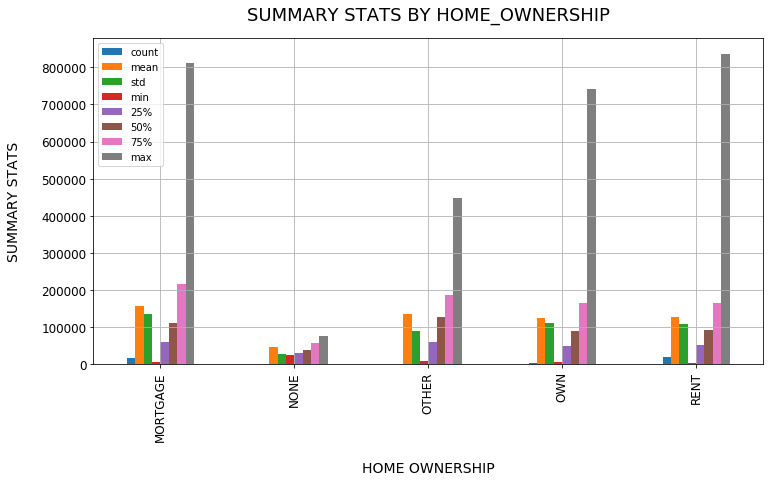

In [964]:
## create layout
fig_ho_1, ax_ho_1 = plt.subplots(figsize=ASP_RATIO)

## configure plot
label_ho_1 = {'plot_title': 'SUMMARY STATS BY HOME_OWNERSHIP',
            'pad':18,
            'x_label':'HOME OWNERSHIP',
            'y_label':'SUMMARY STATS',
            'ax_fontsize':14,
            't_fontsize':18,
            'labelpad':20,
            'labelsize':12,
            'ax_obj':ax_ho_1
           }

## plot on the created layout
loan_data.\
groupby('home_ownership')['funded_amnt_inv','int_rate_amnt_derv']\
.describe()['int_rate_amnt_derv'].plot.bar(ax=ax_ho_1);


## label plot
label_plot(**label_ho_1)

plt.grid();

In [858]:
generate_crosstab_summary(loan_data,'home_ownership','loan_status_enc_derv')

loan_status_enc_derv,avg_defaulter_row%,avg_non_defaulter_row%,avg_defaulter_diff_row%,avg_defaulter_col%,avg_non_defaulter_col%,avg_defaulter_diff_col%
home_ownership,,,,,,
MORTGAGE,13.67,86.33,13.67,41.35,44.59,41.35
NONE,0.00,100.00,0.00,0.00,0.01,0.00
OTHER,18.37,81.63,18.37,0.32,0.24,0.32
OWN,14.89,85.11,14.89,7.87,7.68,7.87
RENT,15.36,84.64,15.36,50.45,47.47,50.45


In [954]:
loan_data.home_ownership.mode()

0    RENT
Name: home_ownership, dtype: category
Categories (5, object): [MORTGAGE, NONE, OTHER, OWN, RENT]

In [955]:
loan_data.home_ownership.value_counts()

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

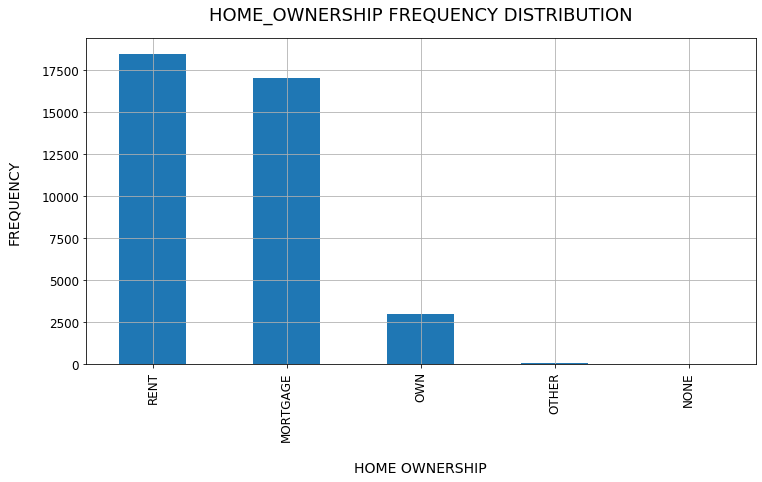

In [969]:
## create layout
fig_ho_2, ax_ho_2 = plt.subplots(figsize=ASP_RATIO)

## configure plot
label_ho_2 = {'plot_title': 'HOME_OWNERSHIP FREQUENCY DISTRIBUTION',
            'pad':18,
            'x_label':'HOME OWNERSHIP',
            'y_label':'FREQUENCY',
            'ax_fontsize':14,
            't_fontsize':18,
            'labelpad':20,
            'labelsize':12,
            'ax_obj':ax_ho_2
           }


## plot frequency home_ownership distribution
loan_data.home_ownership.value_counts().plot(kind='bar', ax=ax_ho_2);
label_plot(**label_ho_2)

plt.grid()

In [970]:
home_ownership_ = pd.DataFrame(loan_data.home_ownership.value_counts())
home_ownership_['rank']= home_ownership_.rank(method='first', ascending=False)
home_ownership_.rename(columns={'home_ownership':'counts'}, inplace=True)
home_ownership_.head(10)

,counts,rank
RENT,18480,1.0
MORTGAGE,17021,2.0
OWN,2975,3.0
OTHER,98,4.0
NONE,3,5.0


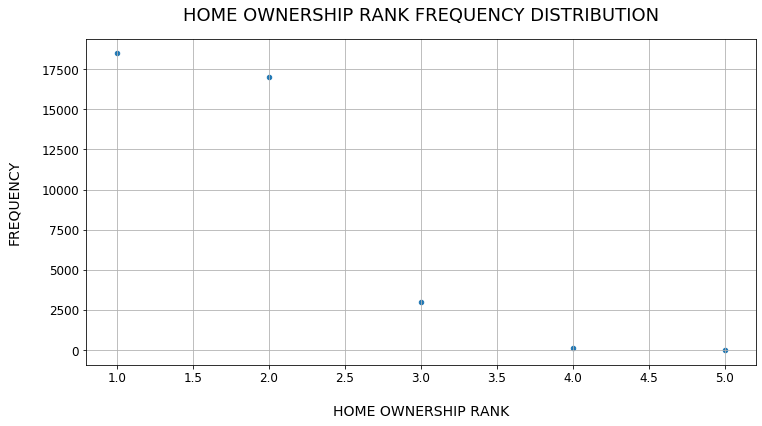

In [994]:
## Rank and frequency distribution plot
fig_ho_3, ax_ho_3 = plt.subplots(figsize=ASP_RATIO)

home_ownership_[['rank','counts']].plot(kind='scatter',x='rank',y='counts', ax=ax_ho_3)
label_ho_3 = {'plot_title': 'HOME OWNERSHIP RANK FREQUENCY DISTRIBUTION',
            'pad':18,
            'x_label':'HOME OWNERSHIP RANK',
            'y_label':'FREQUENCY',
            'ax_fontsize':14,
            't_fontsize':18,
            'labelpad':20,
            'labelsize':12,
#             'x_scale':'linear',
#             'y_scale':'log',
            'ax_obj':ax_ho_3
           }
configure_plot(**label_ho_3)
plt.grid()

<h2> <u>Employee Title variable analysis</u> </h2>

In [172]:
emp_title_ = pd.DataFrame(loan_data.emp_title.value_counts())
emp_title_['rank']= emp_title_.rank(method='first', ascending=False)
emp_title_.rename(columns={'emp_title':'counts'}, inplace=True)
emp_title_.head(10)

,counts,rank
US Army,131,1.0
Bank of America,107,2.0
IBM,65,3.0
AT&T,57,4.0
Kaiser Permanente,56,5.0
Wells Fargo,52,6.0
UPS,52,7.0
USAF,52,8.0
US Air Force,51,9.0
Walmart,45,10.0


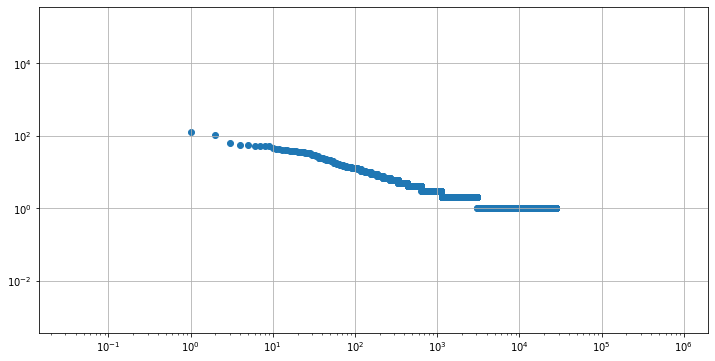

In [173]:
## Rank and frequency distribution plot
fig = plt.figure(figsize=ASP_RATIO)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.scatter(emp_title_['rank'],emp_title_['counts']);

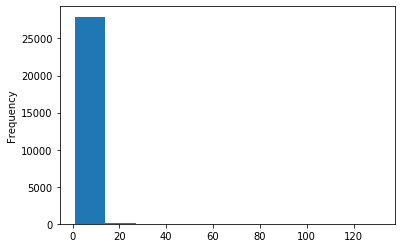

In [999]:
loan_data.emp_title.value_counts().plot.hist();

In [1005]:
top_40_title = loan_data.emp_title.value_counts().sort_values(ascending=False)[:40].index.to_list()

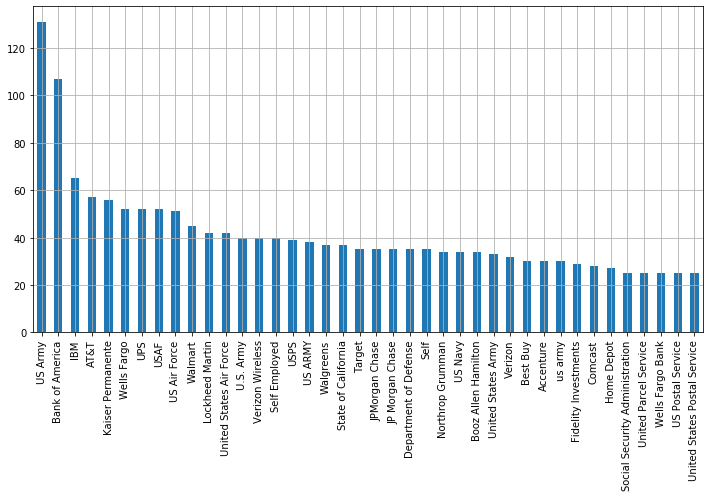

In [998]:
loan_data.emp_title.value_counts()[:40].plot.bar(figsize=ASP_RATIO);
plt.grid()

In [1018]:
loan_data.loc[loan_data.emp_title.isin(top_40_title),['emp_title','funded_amnt_inv']]

,emp_title,funded_amnt_inv
13,Target,3000.000000
23,Wells Fargo Bank,10000.000000
85,Kaiser Permanente,9200.000000
125,United States Air Force,18000.000000
130,Best Buy,7000.000000
149,Best Buy,8425.000000
160,US Army,8150.000000
194,US Air Force,14000.000000
196,UPS,25000.000000
250,IBM,4000.000000


In [1006]:
generate_crosstab_summary(loan_data[loan_data.emp_title.isin(top_40_title)]\
                          ,'emp_title','loan_status_enc_derv')

loan_status_enc_derv,avg_defaulter_row%,avg_non_defaulter_row%,avg_defaulter_diff_row%,avg_defaulter_col%,avg_non_defaulter_col%,avg_defaulter_diff_col%
emp_title,,,,,,
AT&T,21.05,78.95,21.05,5.29,3.13,5.29
Accenture,0.00,100.00,0.00,0.00,2.09,0.00
Bank of America,18.69,81.31,18.69,8.81,6.05,8.81
Best Buy,13.33,86.67,13.33,1.76,1.81,1.76
Booz Allen Hamilton,11.76,88.24,11.76,1.76,2.09,1.76
Comcast,17.86,82.14,17.86,2.20,1.60,2.20
Department of Defense,11.43,88.57,11.43,1.76,2.16,1.76
Fidelity Investments,6.90,93.10,6.90,0.88,1.88,0.88
Home Depot,22.22,77.78,22.22,2.64,1.46,2.64


<h2> <u>Annual Income variable analysis</u> </h2>

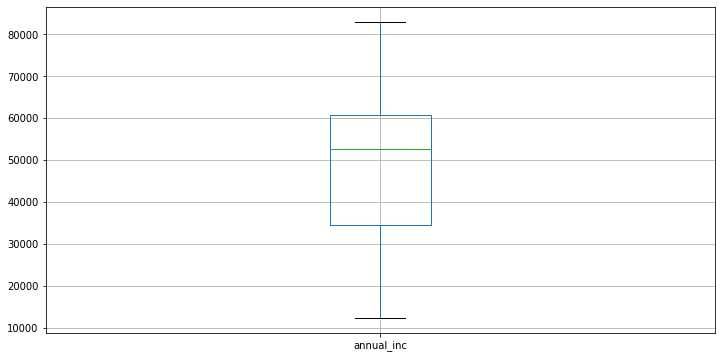

In [174]:
## boxplot to analyze the distribution of annual_income variable 
annual_inc_filter1 = (loan_data['annual_inc'] >=39000) & (loan_data['annual_inc'] <=83000)

loan_data.loc[annual_inc_filter1, 'annual_inc']\
.describe()\
.plot.box(figsize=ASP_RATIO)

plt.grid()

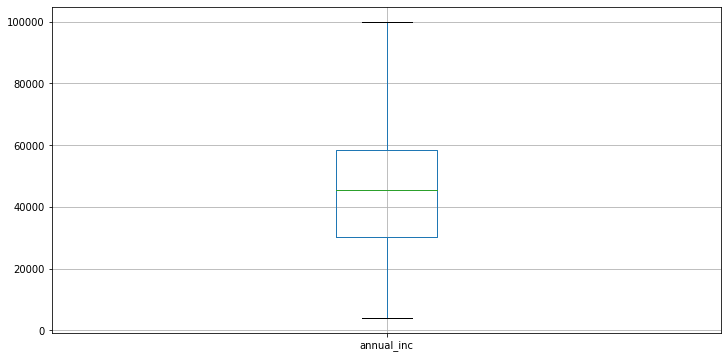

In [175]:
annual_inc_filter2 = (loan_data['annual_inc'] <=10**5)

loan_data.loc[annual_inc_filter2, 'annual_inc']\
.describe()\
.plot.box(figsize=ASP_RATIO)

plt.grid()

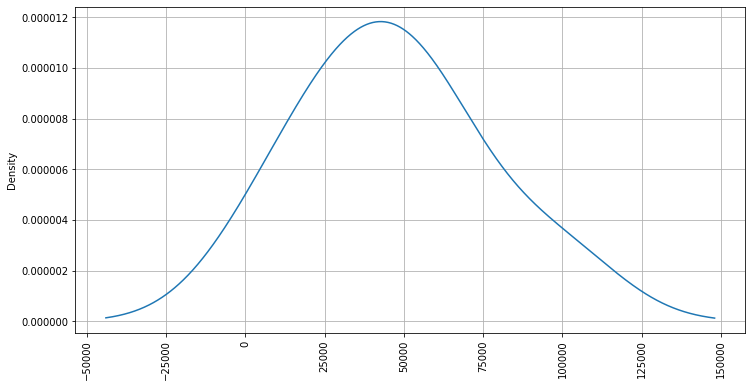

In [176]:
loan_data.loc[annual_inc_filter2,'annual_inc']\
.describe()\
.plot.density(rot=90, figsize=ASP_RATIO);

plt.grid()

In [177]:
loan_data.loc[annual_inc_filter2, 'annual_inc'].describe()

count     33096.000000
mean      54718.949504
std       21255.672109
min        4000.000000
25%       38400.000000
50%       52800.000000
75%       70000.000000
max      100000.000000
Name: annual_inc, dtype: float64

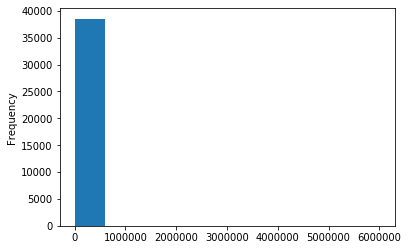

In [178]:
loan_data.annual_inc.plot.hist()

<h2> <u>Delinquency for the last 2 years variable analysis</u> </h2>

In [179]:
loan_data.delinq_2yrs.value_counts()

0     34386
1      3207
2       673
3       212
4        60
5        21
6        10
7         4
8         2
11        1
9         1
Name: delinq_2yrs, dtype: int64

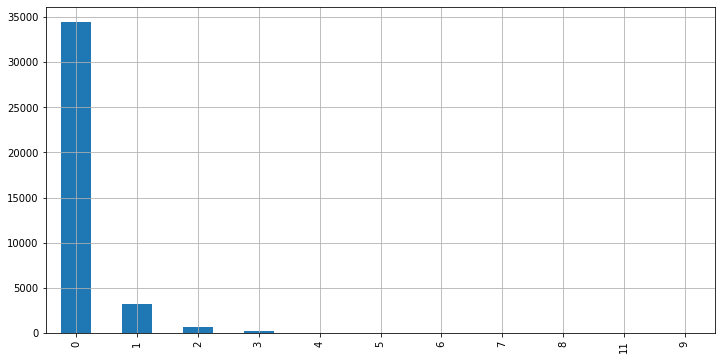

In [180]:
loan_data.loc[:,'delinq_2yrs'].\
value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Employee Job Experience variable analysis</u> </h2>

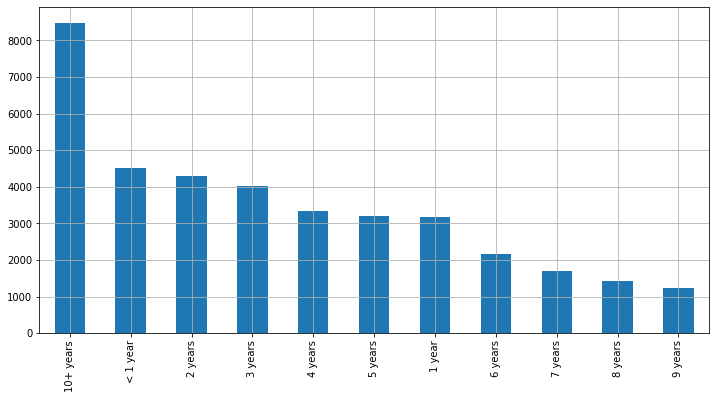

In [181]:
loan_data['emp_length'].value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Funded Amount variable analysis</u> </h2>

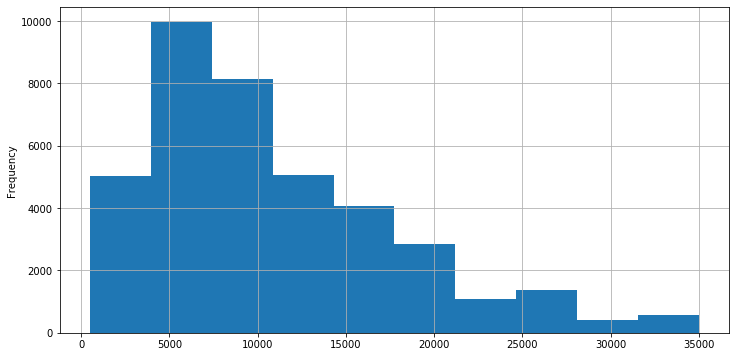

In [182]:
loan_data.funded_amnt.plot.hist(figsize=ASP_RATIO);
plt.grid()

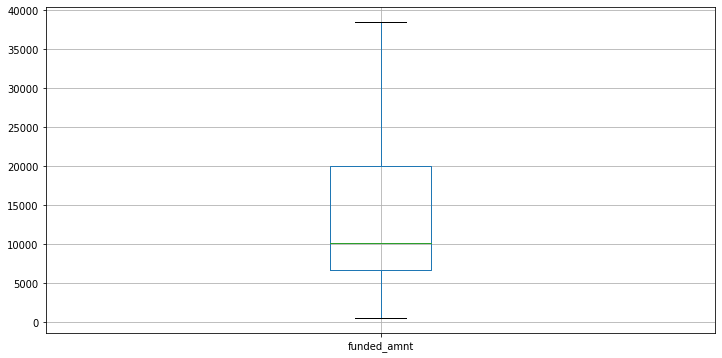

In [183]:
loan_data.funded_amnt.describe().plot.box(figsize=ASP_RATIO)
plt.grid()


<h2> <u>State Address variable analysis</u> </h2>

In [184]:
loan_data.addr_state.shape

(38577,)

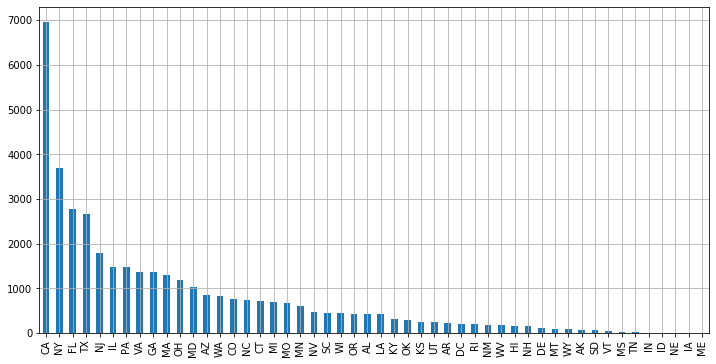

In [185]:
loan_data.addr_state.value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Interest Rate variable analysis</u> </h2>

In [186]:
loan_data.int_rate_derv.shape

(38577,)

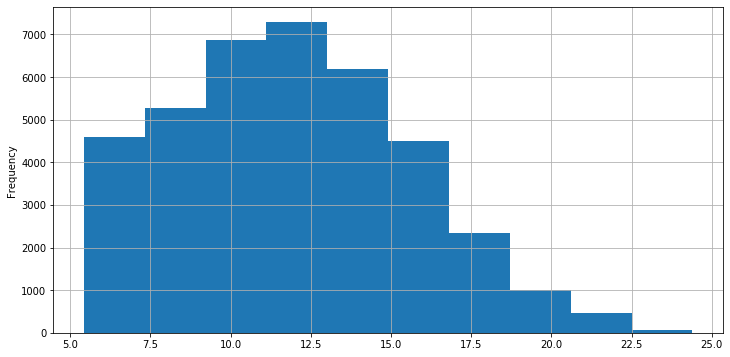

In [187]:
loan_data.int_rate_derv.plot.hist(figsize=ASP_RATIO);
plt.grid()

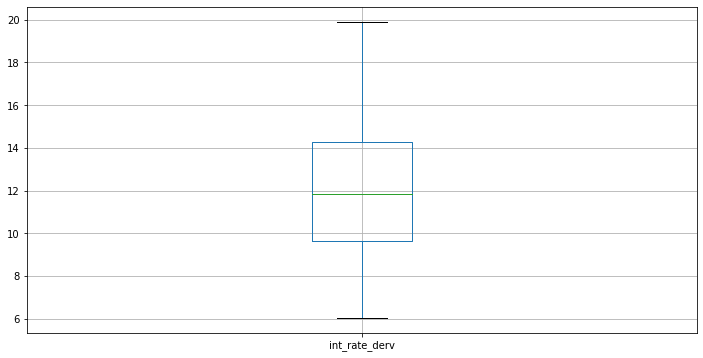

In [188]:
loan_data.loc[(loan_data.int_rate_derv > 6)  & (loan_data.int_rate_derv <= 20), 'int_rate_derv']\
.plot.box(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Interest Amount variable analysis</u> </h2>

In [189]:
loan_data.int_rate_amt_derv.describe()

count     38577.000000
mean     139987.282779
std      121697.735020
min        4035.000000
25%       55160.000000
50%      100620.000000
75%      186900.000000
max      836850.000000
Name: int_rate_amt_derv, dtype: float64

In [190]:
operator.gt(12,6)

True

In [191]:
import operator as op

operatorlookup = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul,
    '/': operator.truediv
}

In [192]:
op.le(5,6)

True

In [193]:
create_bins(loan_data,'int_rate_amt_derv','int_rate_amt_encode',10000,20000,30000,40000,50000,80000,100000)

In [194]:
loan_data.int_rate_amt_encode.value_counts().sort_index()

interval_0      226
interval_1     1279
interval_2     1992
interval_3     2368
interval_4     2473
interval_5     7308
interval_6     3583
interval_7    19348
Name: int_rate_amt_encode, dtype: int64

In [195]:
loan_data['int_rate_amt_derv'] = loan_data['int_rate_derv']*loan_data['loan_amnt']

In [196]:
loan_data.loc[filt_list[2],'int_rate_amt_derv'].min()

50008.0

In [197]:
int_rate_amt_int1 = (loan_data.int_rate_amt_derv <= 20000)
int_rate_amt_int2 = (loan_data.int_rate_amt_derv > 20000) & (loan_data.int_rate_amt_derv <= 50000)
int_rate_amt_int3 = (loan_data.int_rate_amt_derv > 50000) & (loan_data.int_rate_amt_derv <= 80000)
int_rate_amt_int4 = (loan_data.int_rate_amt_derv > 80000) & (loan_data.int_rate_amt_derv <= 100000)
int_rate_amt_int5 = (loan_data.int_rate_amt_derv > 100000)

loan_data.loc[int_rate_amt_int1,'int_rate_amt_derv_encode'] = 1
loan_data.loc[int_rate_amt_int2,'int_rate_amt_derv_encode'] = 2 
loan_data.loc[int_rate_amt_int3,'int_rate_amt_derv_encode'] = 3 
loan_data.loc[int_rate_amt_int4,'int_rate_amt_derv_encode'] = 4
loan_data.loc[int_rate_amt_int5,'int_rate_amt_derv_encode'] = 5 

In [198]:
loan_data.int_rate_amt_derv_encode.value_counts().sort_index()

1.0     1505
2.0     6833
3.0     7308
4.0     3583
5.0    19348
Name: int_rate_amt_derv_encode, dtype: int64

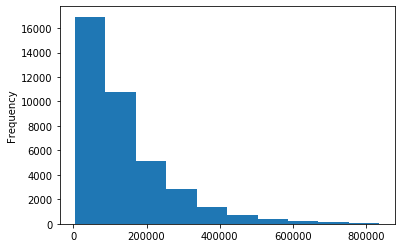

In [199]:
loan_data.int_rate_amt_derv.plot.hist()

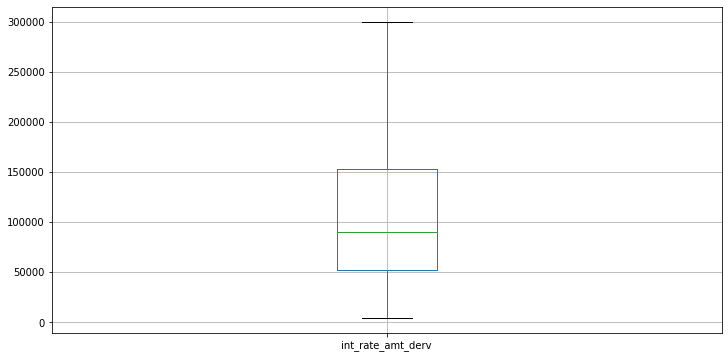

In [200]:
loan_data.loc[loan_data.int_rate_amt_derv <= 3*(10**5),'int_rate_amt_derv'].plot.box(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Target variable analysis</u> </h2>

In [201]:
loan_data.is_defaulter_derv.shape

(38577,)

In [202]:
non_defaulter_percnt = round(loan_data.is_defaulter_derv\
      .value_counts()[0]/loan_data\
      .is_defaulter_derv\
      .value_counts()\
      .sum()*100,2)

defaulter_percnt = round(loan_data.is_defaulter_derv\
      .value_counts()[1]/loan_data\
      .is_defaulter_derv\
      .value_counts()\
      .sum()*100,2)

print(f"DEFAULTER PERCENT --> {str(defaulter_percnt)+'%'}\nNON_DEFAULTER PERCENT --> {str(non_defaulter_percnt)+ '%'}")

DEFAULTER PERCENT --> 14.59%
NON_DEFAULTER PERCENT --> 85.41%


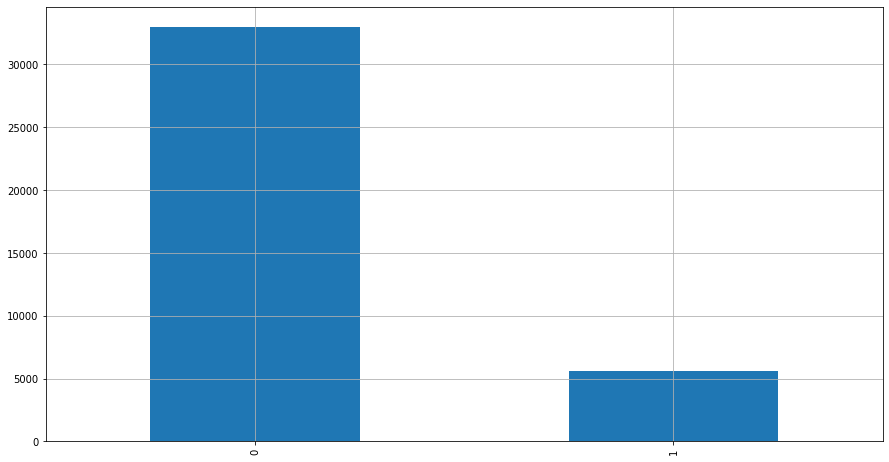

In [203]:
loan_data.is_defaulter_derv.value_counts().plot.bar(figsize=(15,8));
plt.grid()

<h2> <u>Purpose variable analysis</u> </h2>

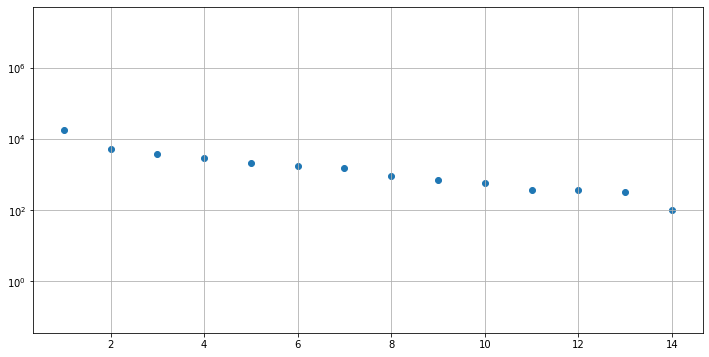

In [204]:
purpose_ = pd.DataFrame(loan_data.purpose.value_counts())
purpose_['rank']= purpose_.rank(method='first', ascending=False)
purpose_.rename(columns={'purpose':'counts'}, inplace=True)
purpose_.head(10)

fig = plt.figure(figsize=ASP_RATIO)
plt.grid()
plt.xscale('linear')
plt.yscale('log')
plt.scatter(purpose_['rank'],purpose_['counts']);

In [205]:
loan_data.purpose.shape

(38577,)

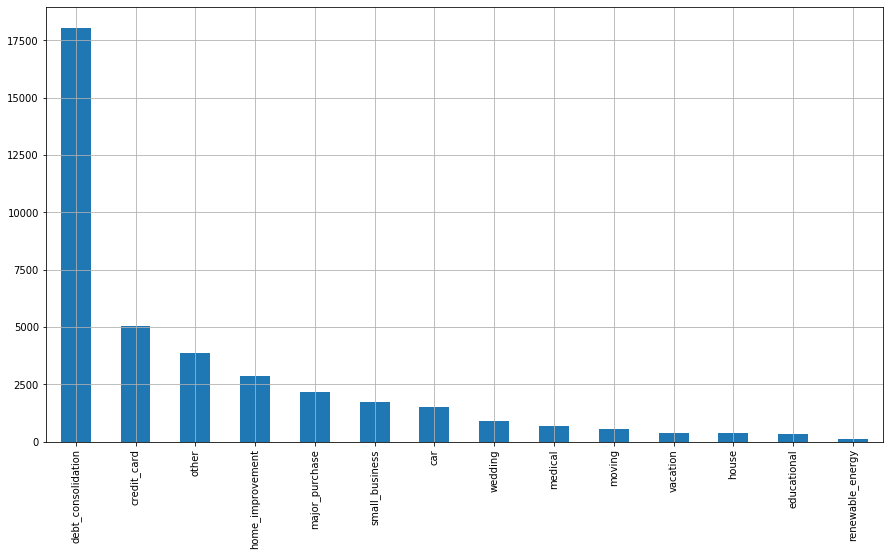

In [206]:
loan_data.purpose.value_counts().plot.bar(figsize=(15,8));
plt.grid()

<h2> <u>Title variable analysis</u> </h2>

In [207]:
loan_data.title.shape

(38577,)

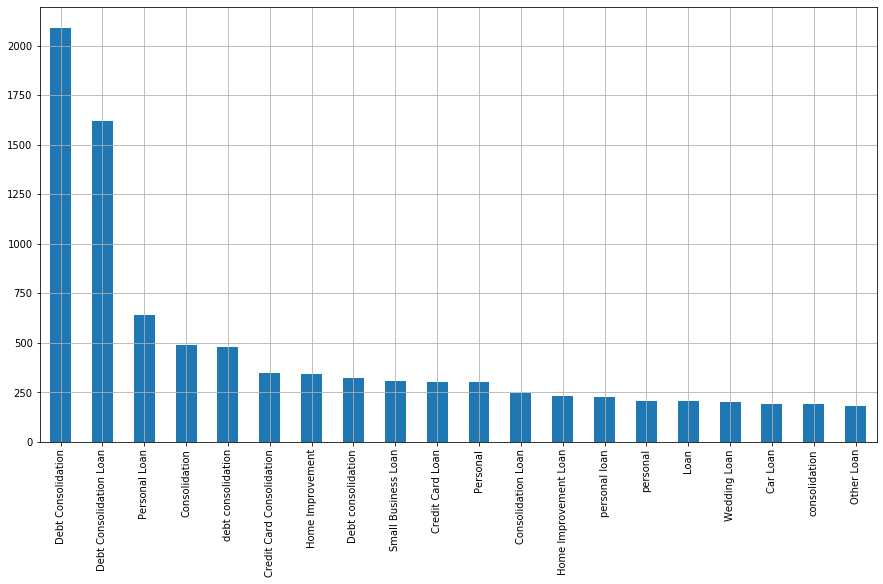

In [208]:
loan_data.title.value_counts()[:20].plot.bar(figsize=(15,8))
plt.grid()

<h2> <u>Grade variable analysis</u> </h2>

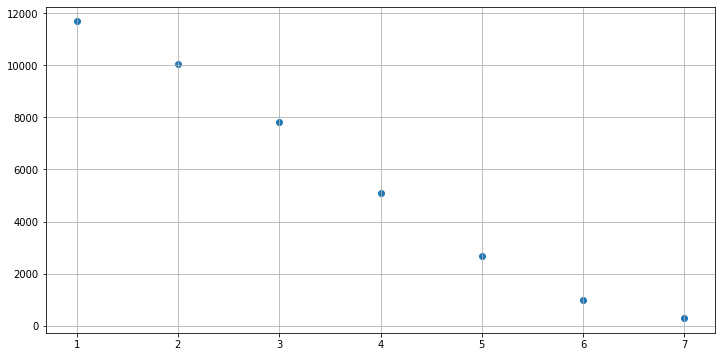

In [209]:
grade_ = pd.DataFrame(loan_data.grade.value_counts())
grade_['rank']= grade_.rank(method='first', ascending=False)
grade_.rename(columns={'grade':'counts'}, inplace=True)
grade_.head(10)

fig = plt.figure(figsize=ASP_RATIO)
plt.grid()
plt.xscale('linear')
plt.yscale('linear')
plt.scatter(grade_['rank'],grade_['counts']);

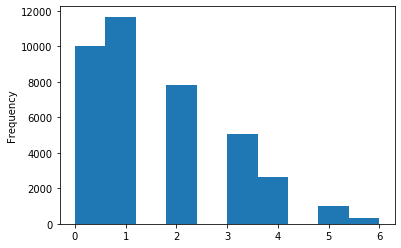

In [210]:
loan_data['grade_encoded_derv'].plot.hist()

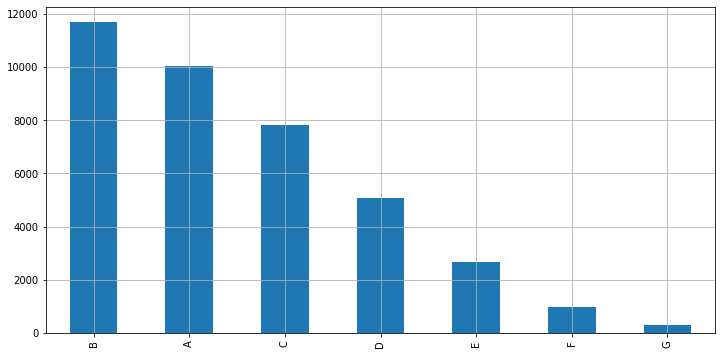

In [211]:
loan_data.grade.value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid();

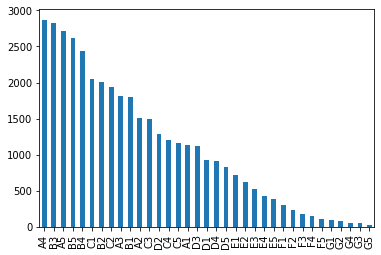

In [212]:
loan_data.sub_grade.value_counts().plot.bar()

In [213]:
round((loan_data.groupby('grade')['funded_amnt_inv'].sum()/loan_data['funded_amnt_inv'].sum())*100,2)

grade
A    20.75
B    30.03
C    19.57
D    14.47
E     9.64
F     4.11
G     1.43
Name: funded_amnt_inv, dtype: float64

In [214]:
fainv1 = (loan_data.funded_amnt_inv <= 5000)
fainv2 = (loan_data.funded_amnt_inv > 5000)& (loan_data.funded_amnt_inv <= 10000)
fainv3 = (loan_data.funded_amnt_inv > 10000)& (loan_data.funded_amnt_inv <= 15000)
fainv4 = (loan_data.funded_amnt_inv > 15000)

loan_data.loc[fainv1,'funded_amnt_inv_encode_derv'] = 1
loan_data.loc[fainv2,'funded_amnt_inv_encode_derv'] = 2
loan_data.loc[fainv3,'funded_amnt_inv_encode_derv'] = 3
loan_data.loc[fainv4,'funded_amnt_inv_encode_derv'] = 4

In [215]:
loan_data.funded_amnt_inv_encode_derv.unique()

array([1., 2., 3., 4.])

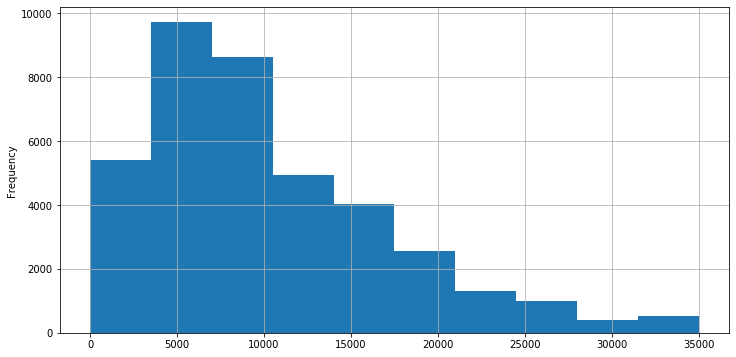

In [216]:
loan_data.funded_amnt_inv.plot.hist(figsize=ASP_RATIO);
plt.grid()

In [217]:
def encode_pub_rec(val):
    if val == 1 or val==0:
        return val
    else:
        return 1
    

In [218]:
loan_data['pub_rec_derv']= loan_data.pub_rec.apply(encode_pub_rec)

In [219]:
loan_data.pub_rec.value_counts()

0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64

<h1> <center><u>Bivariate Analysis</u></center></h1>

<h4> <u>No of Months passed since last time, when the payment of loan was missed vs Target variable analysis</u> </h4>

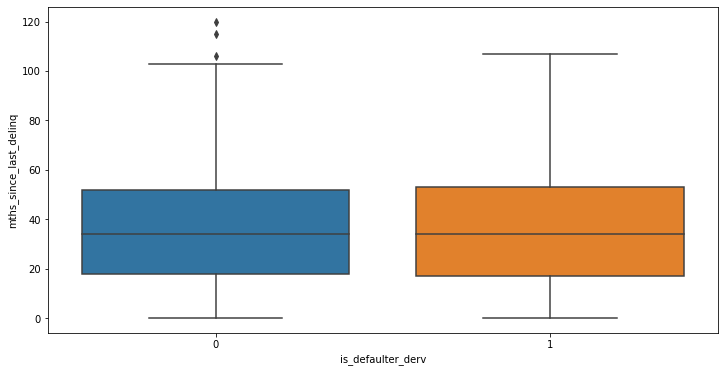

In [220]:
fig_dims = ASP_RATIO
fig_msld, ax_msld = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='mths_since_last_delinq', data=loan_data, ax=ax_msld);

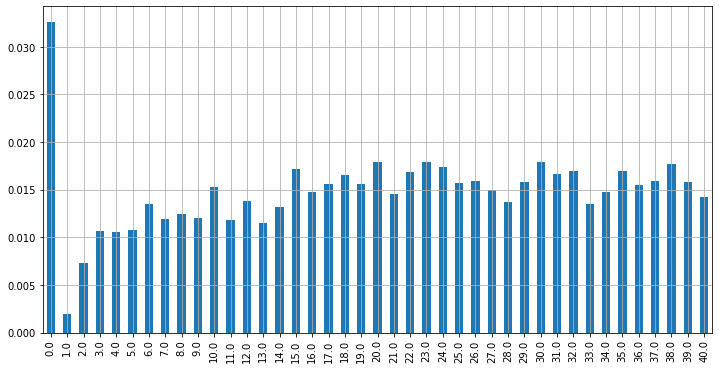

In [221]:
(loan_data[(loan_data.is_defaulter_derv==0)]['mths_since_last_delinq'].value_counts()/\
loan_data[(loan_data.is_defaulter_derv==0)]['mths_since_last_delinq'].value_counts().sum()).sort_index()\
[:40].plot(kind='bar', figsize=ASP_RATIO)
plt.grid()

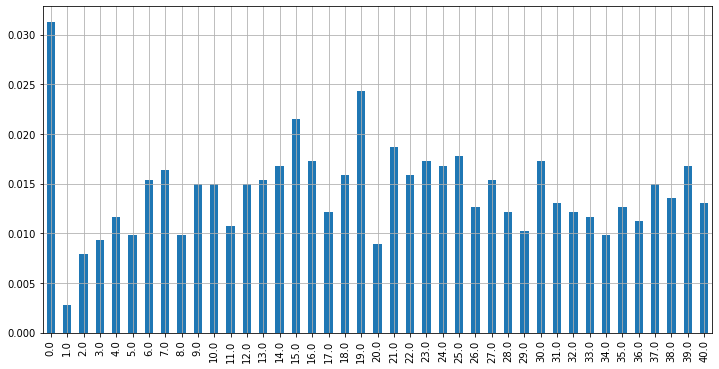

In [222]:
(loan_data[(loan_data.is_defaulter_derv==1)]['mths_since_last_delinq'].value_counts()/\
loan_data[(loan_data.is_defaulter_derv==1)]['mths_since_last_delinq'].value_counts().sum()).sort_index()\
[:40].plot(kind='bar', figsize=ASP_RATIO)
plt.grid()

In [223]:
create_bins(loan_data,'mths_since_last_delinq','mths_since_last_delinq_encode')

IndexError: tuple index out of range

In [ ]:
create_bins()

In [ ]:
msld1 = (loan_data.mths_since_last_delinq <= 20)
msld2 = (loan_data.mths_since_last_delinq > 20)& (loan_data.mths_since_last_delinq <= 50)
msld3 = (loan_data.mths_since_last_delinq > 50)


loan_data.loc[msld1,'mths_since_last_delinq_derv'] = 1 
loan_data.loc[msld2,'mths_since_last_delinq_derv'] = 2 
loan_data.loc[msld3,'mths_since_last_delinq_derv'] = 3


woe_df_msld = pd.DataFrame()

min_val =[
    loan_data.loc[msld1,'mths_since_last_delinq'].min(),
loan_data.loc[msld2,'mths_since_last_delinq'].min(),
loan_data.loc[msld3,'mths_since_last_delinq'].min()]

max_val =[
    loan_data.loc[msld1,'mths_since_last_delinq'].max(),
    loan_data.loc[msld2,'mths_since_last_delinq'].max(),
    loan_data.loc[msld3,'mths_since_last_delinq'].max()
]

count_events = [
loan_data.loc[msld1 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[msld2 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[msld3 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count()]

count_non_events =[
loan_data.loc[msld1 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[msld2 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[msld3 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count()
]

loan_data.mths_since_last_delinq_derv.value_counts().sort_index()

count = loan_data.mths_since_last_delinq_derv.value_counts().sort_index().values.tolist()
loan_data.mths_since_last_delinq_derv.value_counts().sort_index().values.tolist()

In [435]:
loan_data.is_defaulter_derv.unique()[0]

0

In [ ]:
'mths_since_last_delinq','mths_since_last_delinq_cat'

In [463]:
def calculate_woe(df, col_names, bin_tar_col,*intvls):

    intervals = create_bins(df, col_names[0], col_names[1], *intvls)
    woe_df_ = pd.DataFrame()
    
    min_val = [df.loc[intvl,col_names[0]].min() for intvl in intervals]
    max_val = [df.loc[intvl,col_names[0]].max() for intvl in intervals]
    
    count_events = [df.loc[intvl & (df[bin_tar_col]==df[bin_tar_col].unique()[0]),\
                           bin_tar_col].count() for intvl in intervals]
    count_non_events = [df.loc[intvl & (df[bin_tar_col]==df[bin_tar_col].unique()[1])\
                               ,bin_tar_col].count() for intvl in intervals]
    
    df[col_names[1]].value_counts().sort_index()
    count = df[col_names[1]].value_counts().sort_index().values.tolist()
    
    woe_df_['min_val_'] = min_val
    woe_df_['max_val_'] = max_val
    woe_df_['count_'] = count
    woe_df_['count_events_'] = count_events
    woe_df_['count_non_events_'] = count_non_events
    woe_df_['%_count_events'] = round((woe_df_.count_events_/woe_df_.count_events_.sum()),4)\
    .values*100

    woe_df_['%_non_count_events']= round((woe_df_.count_non_events_/woe_df_.count_non_events_.sum()),4)\
    .values*100

    woe_df_['WOE'] = (woe_df_['%_count_events']/woe_df_['%_non_count_events']).apply(math.log)
    woe_df_['diff_event_%_non_event'] = (woe_df_['%_count_events'] - woe_df_['%_non_count_events'])
    woe_df_['IV'] = round((woe_df_['diff_event_%_non_event']*woe_df_['WOE']),2)
    woe_df_['variable_name'] = "mths_since_last_delinq"
    
    return round(woe_df_['IV'].sum(),2)
    



In [464]:
calculate_woe(loan_data, ['mths_since_last_delinq','mths_since_last_delinq_cat'], 'is_defaulter_derv',20,50)

0.36

In [ ]:
woe_df_msld['variable_name'] = "mths_since_last_delinq"
woe_df_msld['min_val_'] = min_val
woe_df_msld['max_val_'] = max_val
woe_df_msld['count_'] = count
woe_df_msld['count_events_'] = count_events
woe_df_msld['count_non_events_'] = count_non_events
woe_df_msld['%_count_events'] = round((woe_df_msld.count_events_/woe_df_msld.count_events_.sum()),4)\
.values*100

woe_df_msld['%_non_count_events']= round((woe_df_msld.count_non_events_/woe_df_msld.count_non_events_.sum()),4)\
.values*100

woe_df_msld['WOE'] = (woe_df_msld['%_count_events']/woe_df_msld['%_non_count_events']).apply(math.log)
woe_df_msld['diff_event_%_non_event'] = (woe_df_msld['%_count_events'] - woe_df_msld['%_non_count_events'])
woe_df_msld['IV'] = round((woe_df_msld['diff_event_%_non_event']*woe_df_msld['WOE']),2)

In [431]:
dat_list = create_bins(loan_data,'mths_since_last_delinq','mths_since_last_delinq_cat',20,50)

In [433]:
len(dat_list)

3

In [428]:
loan_data.mths_since_last_delinq_cat.value_counts().sort_index()

interval_0    3955
interval_1    6132
interval_2    3585
Name: mths_since_last_delinq_cat, dtype: int64

In [ ]:

msld1 = (loan_data.mths_since_last_delinq <= 20)
msld2 = (loan_data.mths_since_last_delinq > 20)& (loan_data.mths_since_last_delinq <= 50)
msld3 = (loan_data.mths_since_last_delinq > 50)


loan_data.loc[msld1,'mths_since_last_delinq_derv'] = 1 
loan_data.loc[msld2,'mths_since_last_delinq_derv'] = 2 
loan_data.loc[msld3,'mths_since_last_delinq_derv'] = 3


woe_df_msld = pd.DataFrame()

min_val =[
    loan_data.loc[msld1,'mths_since_last_delinq'].min(),
loan_data.loc[msld2,'mths_since_last_delinq'].min(),
loan_data.loc[msld3,'mths_since_last_delinq'].min()]

max_val =[
    loan_data.loc[msld1,'mths_since_last_delinq'].max(),
    loan_data.loc[msld2,'mths_since_last_delinq'].max(),
    loan_data.loc[msld3,'mths_since_last_delinq'].max()
]

count_events = [
loan_data.loc[msld1 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[msld2 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[msld3 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count()]

count_non_events =[
loan_data.loc[msld1 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[msld2 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[msld3 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count()
]

loan_data.mths_since_last_delinq_derv.value_counts().sort_index()

count = loan_data.mths_since_last_delinq_derv.value_counts().sort_index().values.tolist()
loan_data.mths_since_last_delinq_derv.value_counts().sort_index().values.tolist()

woe_df_msld['variable_name'] = "mths_since_last_delinq"
woe_df_msld['min_val_'] = min_val
woe_df_msld['max_val_'] = max_val
woe_df_msld['count_'] = count
woe_df_msld['count_events_'] = count_events
woe_df_msld['count_non_events_'] = count_non_events
woe_df_msld['%_count_events'] = round((woe_df_msld.count_events_/woe_df_msld.count_events_.sum()),4)\
.values*100

woe_df_msld['%_non_count_events']= round((woe_df_msld.count_non_events_/woe_df_msld.count_non_events_.sum()),4)\
.values*100

woe_df_msld['WOE'] = (woe_df_msld['%_count_events']/woe_df_msld['%_non_count_events']).apply(math.log)
woe_df_msld['diff_event_%_non_event'] = (woe_df_msld['%_count_events'] - woe_df_msld['%_non_count_events'])
woe_df_msld['IV'] = round((woe_df_msld['diff_event_%_non_event']*woe_df_msld['WOE']),2)

In [ ]:
pd.crosstab(loan_data.mths_since_last_delinq_derv,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO);
plt.savefig('bar_plot_ann_sal_vs_deflt_state.png')
plt.grid()

In [ ]:
woe_df_msld['variable_name'] = "mths_since_last_delinq"

In [ ]:
woe_df_msld

In [ ]:
round(woe_df_msld.IV.sum(),2)

<h4> <u>Public Rec is a number number of derogatory records, which lender considers risk. Comparision of it vs Target variable analysis</u> </h4>


In [ ]:
fig_ann_inc, ax_pub_rec = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.pub_rec,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_pub_rec);
ax_pub_rec.set_title("PUBLIC RECORDS VS DEFAULTER STATE", pad=20, fontsize=18)
ax_pub_rec.set_xlabel('DEFAULTER STATE', fontsize=18, labelpad=5);
ax_pub_rec.set_ylabel('PUBLIC RECORDS', fontsize=18, labelpad=20);
ax_pub_rec.tick_params(axis='both', which='major', labelsize=20);
# ax_pub_rec.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0);
plt.grid()
plt.savefig('bar_plot_pub_rec_vs_deflt_state.png')

In [ ]:
loan_data.pub_rec.value_counts()

In [ ]:
defaulter_prcnt_pub_rec = round((loan_data[loan_data.is_defaulter_derv==1]['pub_rec'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==1]['pub_rec'].value_counts().sum())*100,2)

non_defaulter_pub_rec = round((loan_data[loan_data.is_defaulter_derv==0]['pub_rec'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==0]['pub_rec'].value_counts().sum())*100,2)

pub_rec_dfltr_vs_non_dfltr = pd.concat([defaulter_prcnt_pub_rec, non_defaulter_pub_rec], axis='columns')

pub_rec_dfltr_vs_non_dfltr.columns = ['Defaulter_prcnt', 'Non_Defaulter_prcnt']

pub_rec_dfltr_vs_non_dfltr['Diff_Defaulter_prcnt_Non_Defaulter_prcnt'] = \
(pub_rec_dfltr_vs_non_dfltr['Defaulter_prcnt']-pub_rec_dfltr_vs_non_dfltr['Non_Defaulter_prcnt'])

pub_rec_dfltr_vs_non_dfltr

In [ ]:
perfrom_chi_2_test(loan_data,'pub_rec','is_defaulter_derv')

<h4> <u>Annual Income vs Target variable analysis</u> </h4>

In [ ]:
MUL_1K = 10**3

l1 =    (loan_data.annual_inc <= 40*MUL_1K)
l2 =    (loan_data.annual_inc > 40*MUL_1K)& (loan_data.annual_inc <= 50*MUL_1K)
l3 =    (loan_data.annual_inc > 50*MUL_1K)& (loan_data.annual_inc <= 80*MUL_1K)
l4 =    (loan_data.annual_inc > 80*MUL_1K) 


loan_data.loc[l1,'annual_inc_derv'] = 1 
loan_data.loc[l2,'annual_inc_derv'] = 2 
loan_data.loc[l3,'annual_inc_derv'] = 3
loan_data.loc[l4,'annual_inc_derv'] = 4


woe_df = pd.DataFrame()

min_val =[
    loan_data.loc[l1,'annual_inc'].min(),
loan_data.loc[l2,'annual_inc'].min(),
loan_data.loc[l3,'annual_inc'].min(),
    loan_data.loc[l4,'annual_inc'].min()
]

max_val =[
    loan_data.loc[l1,'annual_inc'].max(),
    loan_data.loc[l2,'annual_inc'].max(),
    loan_data.loc[l3,'annual_inc'].max(),
    loan_data.loc[l4,'annual_inc'].max()
]

count_events = [
loan_data.loc[l1 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[l2 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[l3 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
    loan_data.loc[l4 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count()
]

count_non_events =[
loan_data.loc[l1 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[l2 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[l3 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
    loan_data.loc[l4 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count()
]

loan_data.annual_inc_derv.value_counts().sort_index()

count = loan_data.annual_inc_derv.value_counts().sort_index().values.tolist()
loan_data.annual_inc_derv.value_counts().sort_index().values.tolist()

woe_df['variable_name'] = 'annual_income'
woe_df['min_val_'] = min_val
woe_df['max_val_'] = max_val
woe_df['count_'] = count
woe_df['count_events_'] = count_events
woe_df['count_non_events_'] = count_non_events
woe_df['%_count_events'] = round((woe_df.count_events_/woe_df.count_events_.sum()),4).values*100
woe_df['%_non_count_events']= round((woe_df.count_non_events_/woe_df.count_non_events_.sum()),4).values*100
woe_df['WOE'] = (woe_df['%_count_events']/woe_df['%_non_count_events']).apply(math.log)
woe_df['diff_event_%_non_event'] = (woe_df['%_count_events'] - woe_df['%_non_count_events'])
woe_df['IV'] = round((woe_df['diff_event_%_non_event']*woe_df['WOE']),2)

In [ ]:
woe_df['variable_name'] = 'annual_income'

In [ ]:
woe_df

In [ ]:
woe_df.IV.sum()

In [ ]:
fig_ann_inc, ax_ann_inc = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.annual_inc_derv,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_ann_inc);

ax_ann_inc.set_title("ANNUAL INCOME VS DEFAULTER STATE", pad=20, fontsize=18)
ax_ann_inc.set_xlabel('DEFAULTER STATE', fontsize=18, labelpad=5);
ax_ann_inc.set_ylabel('ANNUAL INCOME', fontsize=18, labelpad=20);
ax_ann_inc.tick_params(axis='both', which='major', labelsize=20);
ax_ann_inc.set_xticklabels(['<40K', '40K to 50K','50K to 80K','>80K'], rotation=0);
plt.grid()
plt.savefig('bar_plot_ann_sal_vs_deflt_state.png')


In [ ]:
fig_dims = ASP_RATIO
fig, ax_ann_inc_box = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='annual_inc', data=loan_data[loan_data.annual_inc < (1*(10**5))],\
            ax=ax_ann_inc_box);

ax_ann_inc_box.set_title("ANNUAL INCOME VS DEFAULTER STATE", pad=20, fontsize=18)
ax_ann_inc_box.set_xlabel('DEFAULTER STATE', fontsize=18, labelpad=5);
ax_ann_inc_box.set_ylabel('ANNUAL INCOME', fontsize=18, labelpad=20);
ax_ann_inc_box.tick_params(axis='both', which='major', labelsize=20);
ax_ann_inc_box.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0);
plt.grid()
plt.savefig('box_plot_ann_sal_vs_deflt_state.png')


In [328]:
perfrom_chi_2_test(loan_data,'is_defaulter_derv','annual_inc_derv')

 P_value for chi_2 test between is_defaulter_derv and annual_inc_derv 0.0


<h4> <u>Interest Amount vs Target variable analysis</u> </h4>

In [420]:
def plot_crosstab(df=None, col_names=None, x_label=None, y_label=None, labelsize=None, \
                  labelpad=None, pad=None, t_fontsize=None, ax_fontsize=None, plot_title=None, \
                  x_ticklabels=None, rotation=None, estimator=None, color=None, ls=None, \
                  hline=False, vline=False, aspect_ratio=None, sub_plots=False):
    if  ~sub_plots:
        fig_obj, ax_obj = plt.subplots(figsize=aspect_ratio)

    
    pd.crosstab(df[col_names[0]], df[col_names[1]])\
    .plot(kind='bar', ax=ax_obj);
    
    ax_obj.set_title(plot_title, pad=pad, fontsize=t_fontsize);
    ax_obj.set_xlabel(x_label, fontsize=ax_fontsize, labelpad=labelpad);
    ax_obj.set_ylabel(y_label, fontsize=ax_fontsize, labelpad=labelpad);
    ax_obj.tick_params(axis='both', which='major', labelsize=labelsize);
    ax_obj.set_xticklabels(x_ticklabels, rotation=rotation);
    
    if hline:
        ax_obj.axhline(estimator, ls=ls, color=color)
    if vline:
        ax_obj.axvline(estimator, ls=ls, color=color)
    

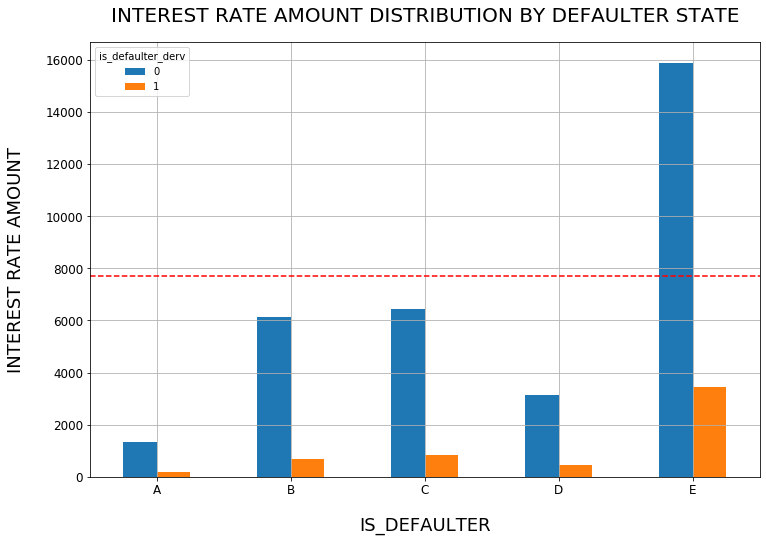

In [421]:


label_name={'plot_title':"INTEREST RATE AMOUNT DISTRIBUTION BY DEFAULTER STATE",
    'x_label':"IS_DEFAULTER",
    'y_label':"INTEREST RATE AMOUNT",
    't_fontsize':20,
    'ax_fontsize':18,
    'labelpad':20,
    'labelsize':12,
    'pad':20,
    'x_ticklabels':['A','B','C','D','E'],
    'color':'r',
    'ls':'--',
    'hline':True,
    'estimator':loan_data.int_rate_amt_derv_encode.value_counts().mean(),
    'df':loan_data,
    'col_names':['int_rate_amt_derv_encode','is_defaulter_derv'],
    'aspect_ratio':(12,8)
           }



plot_crosstab(**label_name)

# ax_int_rate_amnt_bar.set(**label_name)
# ax_int_rate_amnt_bar.axhline(loan_data.int_rate_amt_encode.value_counts().mean(), ls='--', color='r')
# ax_int_rate_amnt_bar.set_title("INTEREST RATE AMOUNT DISTRIBUTION BY DEFAULTER STATE", pad=20, fontsize=18)
# ax_int_rate_amnt_bar.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
# ax_int_rate_amnt_bar.set_ylabel('INTEREST RATE AMOUNT', fontsize=18, labelpad=20);
# ax_int_rate_amnt_bar.tick_params(axis='both', which='major', labelsize=12);
# ax_int_rate_amnt_bar.set_xticklabels(['0 to 20K','20K to 50K','50K to 80K','80K to 100K','100K to inf']\
#                                     , rotation=30);
plt.grid()
# plt.savefig('bar_int_rate_vs_defaulter.png')

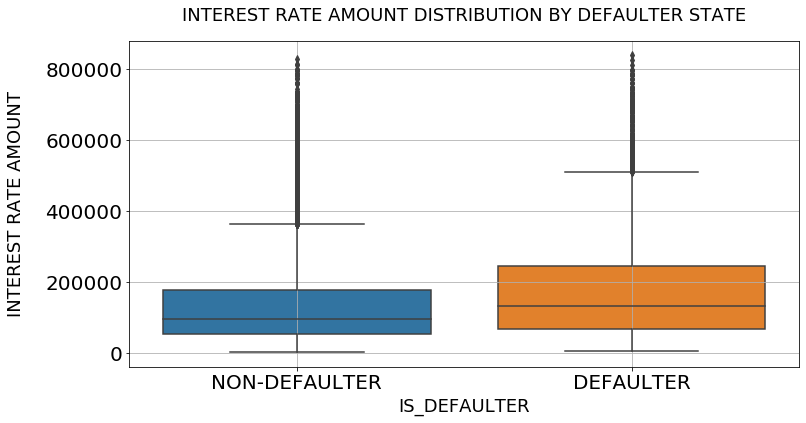

In [315]:
fig_int_rate_amnt_bar, ax_int_rate_amnt_box = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='int_rate_amt_derv', data=loan_data, ax=ax_int_rate_amnt_box);
ax_int_rate_amnt_box.set_title("INTEREST RATE AMOUNT DISTRIBUTION BY DEFAULTER STATE", pad=20, fontsize=18)
ax_int_rate_amnt_box.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_int_rate_amnt_box.set_ylabel('INTEREST RATE AMOUNT', fontsize=18, labelpad=20);
ax_int_rate_amnt_box.tick_params(axis='both', which='major', labelsize=20);
ax_int_rate_amnt_box.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0)
plt.grid()
plt.savefig('box_int_rate_amnt.png')

In [331]:
perfrom_chi_2_test(loan_data,'int_rate_amt_derv_encode','is_defaulter_derv')

 P_value for chi_2 test between int_rate_amt_derv_encode and is_defaulter_derv 0.0


<h4> <u>The actual investment amount issued vs Target variable analysis</u> </h4>

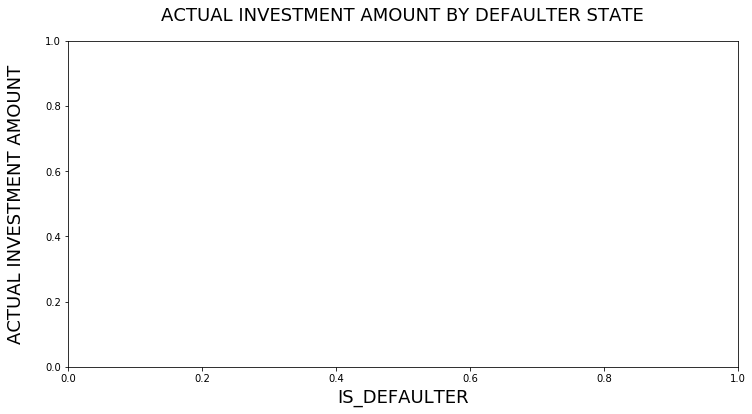

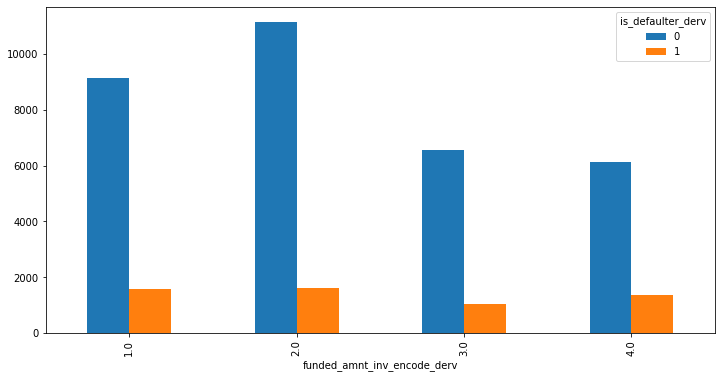

In [332]:
fig_funded_amnt_inv, ax_funded_amnt_inv = plt.subplots(figsize=ASP_RATIO) 
pd.crosstab(loan_data.funded_amnt_inv_encode_derv,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO);
ax_funded_amnt_inv.set_title("ACTUAL INVESTMENT AMOUNT BY DEFAULTER STATE", pad=20, fontsize=18)
ax_funded_amnt_inv.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_funded_amnt_inv.set_ylabel('ACTUAL INVESTMENT AMOUNT', fontsize=18, labelpad=20);
# ax_funded_amnt_inv.tick_params(axis='both', which='major', labelsize=20);
# ax_funded_amnt_inv.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0)



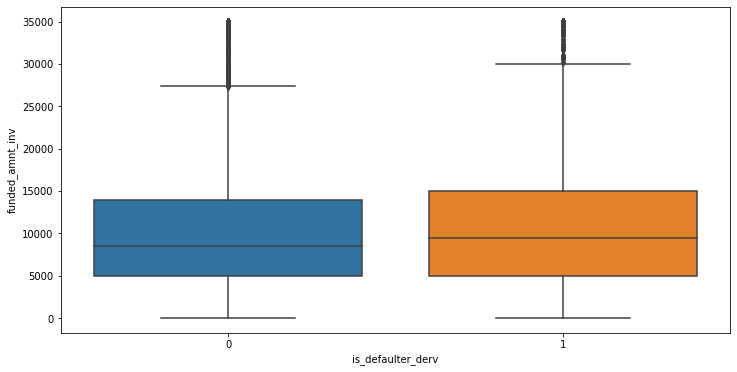

In [333]:
fig2, ax2 = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='funded_amnt_inv', data=loan_data, ax=ax2);

In [334]:
perfrom_chi_2_test(loan_data,'funded_amnt_inv_encode_derv','is_defaulter_derv')

 P_value for chi_2 test between funded_amnt_inv_encode_derv and is_defaulter_derv 0.0


<h4> <u>Purpose vs Target variable analysis</u> </h4>

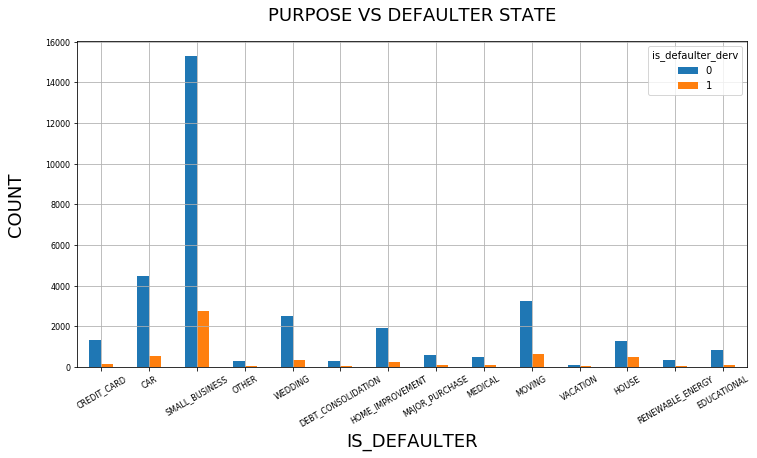

In [335]:
purpose_labels=[label.upper() for label in loan_data.purpose.unique().tolist()]
fig_purpose_bar, ax_purpose_bar = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.purpose,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_purpose_bar);

ax_purpose_bar.set_title("PURPOSE VS DEFAULTER STATE", pad=20, fontsize=18)
ax_purpose_bar.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_purpose_bar.set_ylabel('COUNT', fontsize=18, labelpad=20);
ax_purpose_bar.tick_params(axis='both', which='major', labelsize=8);
ax_purpose_bar.set_xticklabels(purpose_labels, rotation=30)
plt.savefig('bar_purpose.png')
plt.grid()

Purpose of the loan plays a significant role in determing the chances of getting default or not. As it can be observed that if the loan purpose is debt_consolidation, home_improvement, other, small_business and credit_card then there are chances of getting default is high unlike other loan purpose. 

In [336]:
perfrom_chi_2_test(loan_data,'is_defaulter_derv','purpose')

 P_value for chi_2 test between is_defaulter_derv and purpose 0.0


<h4> <u>Home Ownership vs Target variable analysis</u> </h4>

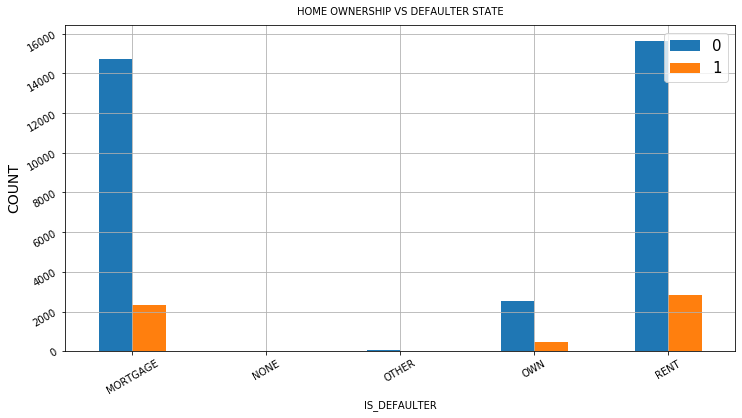

In [337]:
home_own_labels=[label.upper() for label in loan_data.home_ownership.unique().tolist()]
fig_int_rate_amnt_bar, ax_home_ownership = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.home_ownership,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_home_ownership);

ax_home_ownership.set_title("HOME OWNERSHIP VS DEFAULTER STATE", pad=10, fontsize=10)
ax_home_ownership.set_xlabel('IS_DEFAULTER', fontsize=10);
ax_home_ownership.set_ylabel('COUNT', fontsize=14, labelpad=5);
ax_home_ownership.tick_params(axis='both', which='major', labelsize=10, rotation=30);
# ax_home_ownership.set_xticklabels(home_own_labels, rotation=30)

plt.legend(loc=1,prop={'size': 15});
plt.grid()
plt.savefig('home_own_bar.png')

It seems the one who owns has lesser chance of becoming defaulter and greater for those who are on rent and mortgage

In [338]:
perfrom_chi_2_test(loan_data,'home_ownership','is_defaulter_derv')

 P_value for chi_2 test between home_ownership and is_defaulter_derv 0.0


<h4> <u>Grade vs Target variable analysis</u> </h4>

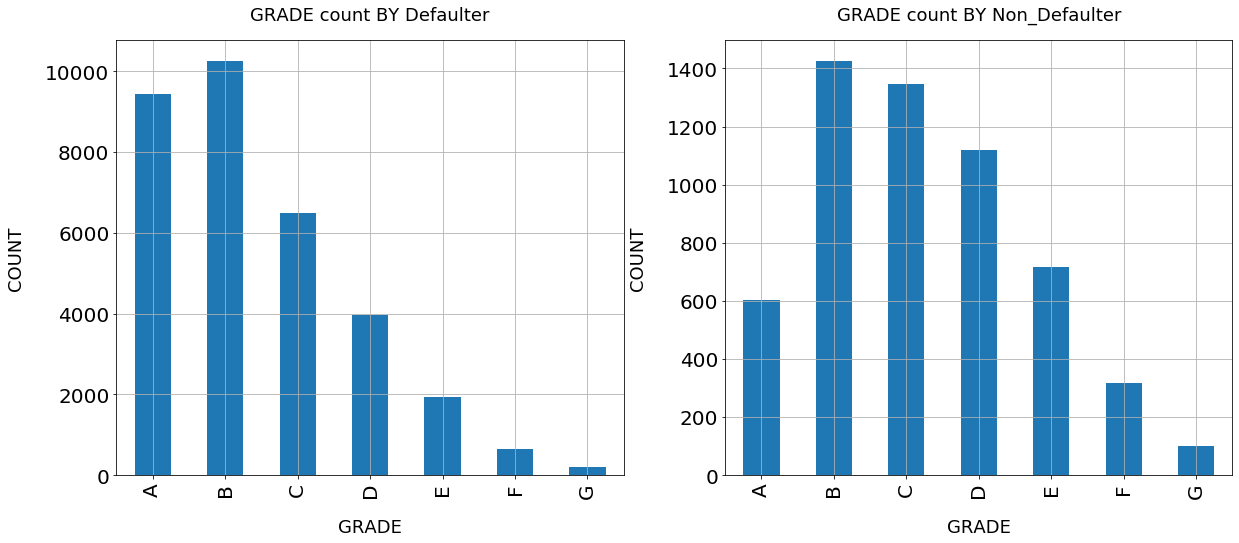

In [339]:
fig_grade, ax_grade = plt.subplots(1,2, figsize=(20,8))

loan_data[loan_data.is_defaulter_derv==0]['grade']\
.value_counts()\
.sort_index()\
.plot(kind='bar', ax=ax_grade[0]);

loan_data[loan_data.is_defaulter_derv==1]['grade']\
.value_counts()\
.sort_index()\
.plot(kind='bar', ax=ax_grade[1]);

ax_grade[0].set_title("GRADE count BY Defaulter", pad=20, fontsize=18)
ax_grade[0].set_xlabel('GRADE', fontsize=18, labelpad=20);
ax_grade[0].set_ylabel('COUNT', fontsize=18, labelpad=20);
ax_grade[0].tick_params(axis='both', which='major', labelsize=20);
ax_grade[0].grid()

ax_grade[1].set_title("GRADE count BY Non_Defaulter", pad=20, fontsize=18)
ax_grade[1].set_xlabel('GRADE', fontsize=18, labelpad=20);
ax_grade[1].set_ylabel('COUNT', fontsize=18, labelpad=20);

ax_grade[1].tick_params(axis='both', which='major', labelsize=20);

ax_grade[1].grid()

In [340]:
defaulter_prcnt = round((loan_data[loan_data.is_defaulter_derv==1]['grade'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==1]['grade'].value_counts().sum())*100,2)

non_defaulter_prcnt = round((loan_data[loan_data.is_defaulter_derv==0]['grade'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==0]['grade'].value_counts().sum())*100,2)

grade_dfltr_vs_non_dfltr = pd.concat([defaulter_prcnt, non_defaulter_prcnt], axis='columns')

grade_dfltr_vs_non_dfltr.columns = ['Defaulter_prcnt', 'Non_Defaulter_prcnt']

grade_dfltr_vs_non_dfltr['Diff_Defaulter_prcnt_Non_Defaulter_prcnt'] = \
(grade_dfltr_vs_non_dfltr['Defaulter_prcnt']-grade_dfltr_vs_non_dfltr['Non_Defaulter_prcnt'])

grade_dfltr_vs_non_dfltr

,Defaulter_prcnt,Non_Defaulter_prcnt,Diff_Defaulter_prcnt_Non_Defaulter_prcnt
A,10.70,28.66,-17.96
B,25.32,31.11,-5.79
C,23.94,19.69,4.25
D,19.87,12.04,7.83
E,12.71,5.91,6.80
F,5.67,1.99,3.68
G,1.79,0.60,1.19


<h4>Findings : When the target variable moves from Non_Defaulter to Defaulter</h4>
<ol>
    <li>There is a significant negative change of <b>(-17.96)% in GRADE A.</b></li>
    <li>There is a significant negative change of <b>(-5.79)% in GRADE B.</b> </li>
    <li>There is a significant positive change of <b>4.25% in GRADE C.</b></li>
    <li>There is a significant positive change of <b>7.83% in GRADE D.</b></li>
    <li>There is a significant positive change of <b>6.80% in GRADE E.</b></li>
    <li>There is a significant positive change of <b>3.68% in GRADE F.</b></li>
    <li>There is a slight positive change of <b>1.19% in GRADE G.</b></li>
</ol>

<h4> <u>Loan issue month vs Target variable analysis</u> </h4>

In [341]:
loan_data['issue_month_derv']= loan_data.issue_d.apply(lambda val: val.split('-')[0])

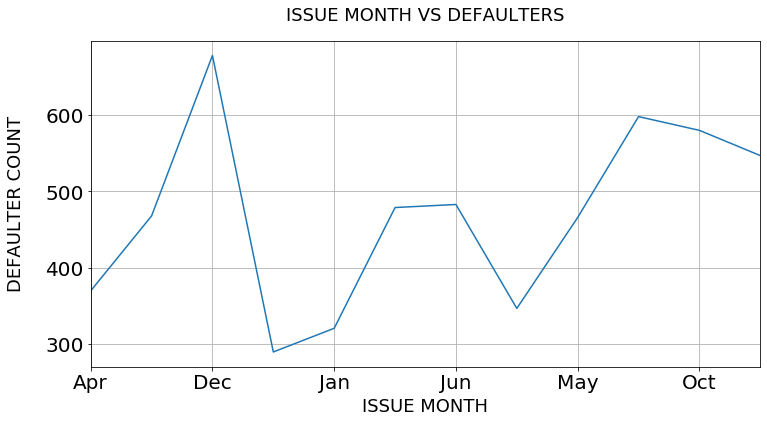

In [342]:
fig_issue_mnth, ax_issue_mnth = plt.subplots()
loan_data[loan_data.is_defaulter_derv==1].groupby('issue_month_derv')['is_defaulter_derv']\
.value_counts()\
.sort_index().unstack().plot(figsize=ASP_RATIO, ax=ax_issue_mnth, legend=False)
ax_issue_mnth.set_title("ISSUE MONTH VS DEFAULTERS", pad=20, fontsize=18)
ax_issue_mnth.set_xlabel('ISSUE MONTH', fontsize=18, labelpad=5);
ax_issue_mnth.set_ylabel('DEFAULTER COUNT', fontsize=18, labelpad=20);
ax_issue_mnth.tick_params(axis='both', which='major', labelsize=20);
# ax_issue_mnth.set_xticklabels(['<40K', '40K to 50K','50K to 80K','>80K'], rotation=0);

plt.savefig('issue_month_dfltr.png')
plt.grid()

<h4> <u>Employee experience vs Target variable analysis</u> </h4>

In [343]:
loan_data[loan_data['is_defaulter_derv']==1]['emp_length'].count()

5399

In [353]:
loan_data.emp_length.fillna(loan_data.emp_length.mode(),inplace =True)

In [395]:
df_pivot = pd.crosstab([loan_data.home_ownership,loan_data.grade,loan_data.emp_length]\
                       ,loan_data.is_defaulter_derv)

In [396]:
df_pivot['defaulter_%'] = df_pivot[0].apply(lambda val: round((val/(df_pivot[0].sum()))*100,2))

In [397]:
df_pivot['non_defaulter_%'] = df_pivot[1].apply(lambda val: round((val/(df_pivot[0].sum()))*100,2))

In [398]:
df_pivot

is_defaulter_derv                   0    1  defaulter_%  non_defaulter_%
home_ownership grade emp_length                                         
MORTGAGE       A     1 year       238   15         0.74             0.05
                     10+ years   1482   81         4.61             0.25
                     2 years      390   14         1.21             0.04
                     3 years      442   22         1.38             0.07
                     4 years      374   16         1.16             0.05
                     5 years      407   21         1.27             0.07
                     6 years      309   15         0.96             0.05
                     7 years      253    6         0.79             0.02
                     8 years      230   15         0.72             0.05
                     9 years      209   14         0.65             0.04
                     < 1 year     370   25         1.15             0.08
               B     1 year       260   34         0.81             0.11
                     10+ years   1345  184         4.18             0.57
                     2 years      415   45         1.29             0.14
                     3 years      399   44         1.24             0.14
                     4 years      341   52         1.06             0.16
                     5 years      402   56         1.25             0.17
                     6 years      266   31         0.83             0.10
                     7 years      219   36         0.68             0.11
                     8 years      193   25         0.60             0.08
                     9 years      177   15         0.55             0.05
                     < 1 year     291   50         0.91             0.16
               C     1 year       166   33         0.52             0.10
                     10+ years    809  173         2.52             0.54
                     2 years      195   40         0.61             0.12
                     3 years      240   53         0.75             0.16
                     4 years      222   29         0.69             0.09
                     5 years      189   50         0.59             0.16
                     6 years      167   36         0.52             0.11
                     7 years      132   30         0.41             0.09
...                               ...  ...          ...              ...
RENT           E     3 years      104   36         0.32             0.11
                     4 years       91   35         0.28             0.11
                     5 years       79   32         0.25             0.10
                     6 years       52   19         0.16             0.06
                     7 years       45   18         0.14             0.06
                     8 years       23   12         0.07             0.04
                     9 years       27   11         0.08             0.03
                     < 1 year     150   51         0.47             0.16
               F     1 year        25   17         0.08             0.05
                     10+ years     41   31         0.13             0.10
                     2 years       42   18         0.13             0.06
                     3 years       43   14         0.13             0.04
                     4 years       31   16         0.10             0.05
                     5 years       26   10         0.08             0.03
                     6 years       13    7         0.04             0.02
                     7 years       17    8         0.05             0.02
                     8 years       12    5         0.04             0.02
                     9 years        3    3         0.01             0.01
                     < 1 year      42   14         0.13             0.04
               G     1 year         1    8         0.00             0.02
                     10+ years     14   11         0.04             0.03
                     2 years       13    2         0.04   

In [379]:
df_pivot.index

MultiIndex(levels=[['MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT'], ['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
           names=['home_ownership', 'emp_length'])

In [382]:
df_pivot.loc['MORTGAGE']['defaulter_%']

emp_length
1 year        2.51
10+ years    14.11
2 years       3.90
3 years       4.15
4 years       3.68
5 years       3.85
6 years       2.88
7 years       2.28
8 years       2.04
9 years       1.87
< 1 year      3.38
Name: defaulter_%, dtype: float64

In [ ]:
df_pivot.loc['',:]

In [409]:
df_pivot.loc[('RENT','A')]['defaulter_%'].sort_index()

emp_length
1 year       1.25
10+ years    1.34
2 years      1.60
3 years      1.37
4 years      1.13
5 years      0.99
6 years      0.61
7 years      0.37
8 years      0.35
9 years      0.29
< 1 year     2.06
Name: defaulter_%, dtype: float64

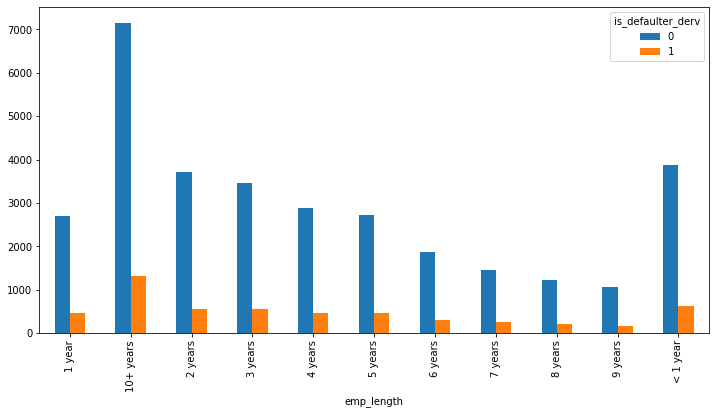

In [350]:
pd.crosstab(loan_data.emp_length,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO);


In [351]:
perfrom_chi_2_test(loan_data,'emp_length','is_defaulter_derv')

 P_value for chi_2 test between emp_length and is_defaulter_derv 0.01


In [193]:
perfrom_chi_2_test(loan_data,'pub_rec','is_defaulter_derv')

 P_value for chi_2 test between pub_rec and is_defaulter_derv 0.0
